# Trump Tweets

This the data behind the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/).

In [2]:
# The usual suspects ...
import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time_series as ts

# And their accomplices ...
from scipy import stats
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint
from warnings import filterwarnings

# Settings
sns.set_style('white')
filterwarnings('ignore')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Getting the data
df = pd.read_csv('data/realDonaldTrump_poll_tweets.csv')

In [4]:
# Size
df.shape

(448, 3)

In [5]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


#### Preprocessing

In [6]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

In [7]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, '')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0           Its just a 2point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17Point Positive Swing ...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

In [9]:
# Emoticons and emojis
# HappyEmoticons
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                       ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                       '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                       'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                       '<3'])

# Sad Emoticons
emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                     ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                     ':c', ':{', '>:\\', ';('])

# Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# Combine
emoticons = emoticons_happy.union(emoticons_sad)

In [10]:
# Text corpus
document = [i for i in df['text']]

# Removing common words and tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
                   'amp', 'kkk', 'hahaha', 'haha', 'ha'])
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

# Removing empty tokens
texts = [text for text in texts if len(text) > 1]

# Removing emojis
texts = [[token for token in text if token not in emoticons] for text in texts]

# Printing the top 10
#pprint(texts[:10])

#### Transformation: Document dictionary

In [11]:
# Create dictionary of document
bag = corpora.Dictionary(texts)
bag.save('models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('models/trump.mm', corpus)

We have assigned a unique integer id to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts and relevant statistics
   
Our corpus is a 448 x 661 matrix.

***

#### Transformation: _tf-idf_

#### Step 1:

In [12]:
# Initialization
tfidf = models.TfidfModel(corpus)

We have initialized (trained) a transaformation model. Different transformation may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features. This is in comparison to ___Latent Semantic Analysis___ & ___Latent Dirichlet Allocation___ which are more involved and take more time.

**A note on transaformations**:
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

#### Step 2:
From now on, ___tf-idf___ is treated as a read-only object that can be used to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights).

In [13]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

We have transformed our corpus (the one we used for training) into a weighted vector. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___.

#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent 10-D space (... num_topics = 10).

In [14]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lsi = lsi[corpus_tfidf]

In [15]:
lsi.print_topics()

[(0,
  '0.587*"thank" + 0.417*"new" + 0.409*"great" + 0.209*"poll" + 0.157*"america" + 0.148*"numbers" + 0.132*"iowa" + 0.116*"reuters" + 0.106*"trump" + 0.103*"support"'),
 (1,
  '0.444*"thank" + -0.339*"trump" + -0.215*"donald" + -0.199*"lead" + -0.197*"carson" + -0.192*"leads" + -0.188*"rubio" + -0.173*"national" + -0.171*"cruz" + -0.145*"debate"'),
 (2,
  '-0.391*"great" + 0.273*"thank" + -0.234*"big" + -0.230*"numbers" + -0.203*"america" + 0.198*"carson" + -0.186*"make" + -0.180*"debate" + 0.172*"rubio" + -0.157*"good"'),
 (3,
  '-0.425*"great" + 0.380*"national" + -0.321*"leads" + 0.263*"iowa" + 0.214*"lead" + -0.196*"rubio" + 0.170*"released" + -0.159*"trump" + -0.155*"carson" + 0.152*"debate"'),
 (4,
  '0.414*"debate" + -0.323*"national" + 0.255*"thank" + 0.247*"said" + -0.206*"new" + -0.182*"leads" + -0.164*"america" + 0.144*"carson" + 0.139*"every" + 0.135*"winning"')]

#### Topics

According to ___LSI___:
<br>
**Topic 1**
> References poll numbers, Iowa, Reuters and Trump.

**Topic 2**
> References Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.

**Topic 3**
> References debate, Carson, and Rubio hinting at what these individuals may have said in the debate.

**Topic 4**
> References great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.

**Topic 5**
> References similar words as topic 4.

In [16]:
# Model persistence: save(), load()
lsi.save('models/trump.lsi')
lsi = models.LsiModel.load('models/trump.lsi')

***
### Similarity

#### Step 1:

In [17]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus])

# Index persistence
index.save('models/trump.index')
index = similarities.MatrixSimilarity.load('models/trump.index')

#### Step 2:

In [18]:
def query_similarity(doc, index=index):
    
    # Performing queries
    vec_bow = bag.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec_lsi = lsi[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec_lsi]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(10):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

In [19]:
query_similarity(doc='Hillary Clinton', index=index)

Tweet Rank #1:	Weight: 0.9744447469711304
Raw text: The refused to use their just in poll numbers where I have a massive lead but instead used numbers where my lead is smaller

Tweet Rank #2:	Weight: 0.9741516709327698
Raw text: Hillary Clinton is not a change agent just the same old status quo She is spending a fortune I am spending very little Close in polls

Tweet Rank #3:	Weight: 0.96927809715271
Raw text: CNBC poll Trump won

Tweet Rank #4:	Weight: 0.9690722823143005
Raw text: Sickening attempt I hope jumps another 10 points

Tweet Rank #5:	Weight: 0.9664850831031799
Raw text: Ted Cruz didnt win Iowa he stole it That is why all of the polls were so wrong and why he got far more votes than anticipated Bad

Tweet Rank #6:	Weight: 0.9579764008522034
Raw text: Watch my interview on Face The Nation now and also the new CBS POLLS which if good for me the media wont report

Tweet Rank #7:	Weight: 0.9378815293312073
Raw text: media is confused they bash trump he rises in polls

Tweet Rank

When we make a query for "Hillary Clinton" to retrieve the respective top tweets associated with her name, we find that the leading tweet with the greatest weight is a strong criticism of Hillary Clinton and her campaign spending. The remaining nine tweets are associated with the polls, darted with references to Donald Trump criticizing poll results not in his favor, him leading against the opposition as well as pitting himself likely to win.

In [20]:
# Performing queries
query_similarity(doc="Ben Carson")

Tweet Rank #1:	Weight: 0.9951412677764893
Raw text: All seven online polls including Drudge and Time with thousands of respondents said I won the debate said I was so so

Tweet Rank #2:	Weight: 0.99360191822052
Raw text: Morning Consult poll Trump Leads

Tweet Rank #3:	Weight: 0.9858934879302979
Raw text: New CNNORC poll w 24 favorability rating on the rise while Jebs declines 60 among women

Tweet Rank #4:	Weight: 0.978705883026123
Raw text: RT New poll finds lean Republicans think most likely to be GOP nominee and has best cha…

Tweet Rank #5:	Weight: 0.975796639919281
Raw text: Rasmussen now beats 3836 nationally

Tweet Rank #6:	Weight: 0.9752370715141296
Raw text: WSJNBC Poll Donald Trump Widens His Lead in Republican Presidential Race

Tweet Rank #7:	Weight: 0.969024658203125
Raw text: GREAT Video Which of these 4 Polls is Suspect Kudos to

Tweet Rank #8:	Weight: 0.965975284576416
Raw text: Good morning America Thank you for all of your support in the latest Drudge poll

Tweet Ran

#### Transformation: LDA

In [21]:
# LDA Transformation
lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lda = lda[corpus_tfidf]

In [22]:
lda.print_topics()

[(0,
  '0.027*"thank" + 0.018*"new" + 0.017*"great" + 0.014*"numbers" + 0.012*"poll" + 0.008*"trump" + 0.008*"cbs" + 0.007*"another" + 0.007*"35" + 0.006*"way"'),
 (1,
  '0.015*"trump" + 0.011*"debate" + 0.010*"leads" + 0.010*"poll" + 0.009*"national" + 0.009*"lead" + 0.008*"said" + 0.008*"winning" + 0.007*"big" + 0.007*"race"'),
 (2,
  '0.013*"thank" + 0.011*"great" + 0.009*"rubio" + 0.009*"new" + 0.009*"bush" + 0.008*"poll" + 0.008*"big" + 0.007*"trump" + 0.007*"carson" + 0.007*"even"'),
 (3,
  '0.014*"great" + 0.011*"new" + 0.010*"trump" + 0.009*"big" + 0.009*"cruz" + 0.009*"wow" + 0.008*"poll" + 0.008*"make" + 0.007*"first" + 0.007*"39"'),
 (4,
  '0.022*"new" + 0.018*"thank" + 0.014*"great" + 0.014*"iowa" + 0.013*"lead" + 0.011*"poll" + 0.011*"reuters" + 0.010*"trump" + 0.008*"news" + 0.007*"donald"')]

In [23]:
# Visualizing LDA topic models
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.060941  0.016929       1        1  27.785646
2      0.031614  0.048508       2        1  20.356993
4     -0.001232 -0.064566       3        1  19.732721
0      0.051033 -0.008381       4        1  16.431301
3     -0.020474  0.007510       5        1  15.693338, topic_info=    Category       Freq         Term      Total  loglift  logprob
11   Default  45.000000        thank  45.000000  30.0000  30.0000
7    Default  39.000000        great  39.000000  29.0000  29.0000
10   Default  46.000000          new  46.000000  28.0000  28.0000
19   Default  22.000000      numbers  22.000000  27.0000  27.0000
102  Default  15.000000      reuters  15.000000  26.0000  26.0000
35   Default  10.000000         make  10.000000  25.0000  25.0000
300  Default   7.000000           39   7.000000  24.0000  24.0000
168  Default   6.000000           35   6.000000  23.0000  23.0000
78   Default   9.000000          cbs   9.000000  22.0000  22.0000
217  Default   8.000000          way   8.000000  21.0000  21.0000
64   Default   7.000000           go   7.000000  20.0000  20.0000
271  Default   7.000000         2016   7.000000  19.0000  19.0000
240  Default  14.000000    hampshire  14.000000  18.0000  18.0000
478  Default   7.000000        field   7.000000  17.0000  17.0000
16   Default  13.000000         even  13.000000  16.0000  16.0000
245  Default  23.000000         iowa  23.000000  15.0000  15.0000
136  Default  17.000000        rubio  17.000000  14.0000  14.0000
448  Default   6.000000          3rd   6.000000  13.0000  13.0000
52   Default   9.000000          far   9.000000  12.0000  12.0000
164  Default   6.000000      beating   6.000000  11.0000  11.0000
361  Default  10.000000        first  10.000000  10.0000  10.0000
357  Default   8.000000   postdebate   8.000000   9.0000   9.0000
26   Default   5.000000          ads   5.000000   8.0000   8.0000
279  Default  10.000000          fox  10.000000   7.0000   7.0000
77   Default   8.000000        think   8.000000   6.0000   6.0000
25   Default  17.000000      america  17.000000   5.0000   5.0000
283  Default   6.000000     received   6.000000   4.0000   4.0000
71   Default   8.000000         like   8.000000   3.0000   3.0000
12   Default  12.000000      another  12.000000   2.0000   2.0000
151  Default   6.000000      showing   6.000000   1.0000   1.0000
..       ...        ...          ...        ...      ...      ...
252   Topic5   1.832074       canada   4.458562   0.9626  -5.7385
304   Topic5   2.331952           us   5.837463   0.9343  -5.4972
89    Topic5   1.652371         come   4.176310   0.9247  -5.8417
36    Topic5   2.185419            q   5.577772   0.9150  -5.5621
461   Topic5   1.754848    marketing   4.529398   0.9037  -5.7816
361   Topic5   4.111461        first  10.652618   0.8999  -4.9302
270   Topic5   2.186161          abc   5.671200   0.8987  -5.5618
457   Topic5   2.327109         wins   6.097179   0.8887  -5.4993
65    Topic5   3.103917  interesting   8.254709   0.8738  -5.2113
81    Topic5   4.881639          wow  15.234190   0.7139  -4.7585
93    Topic5   2.366334       easily   6.481109   0.8444  -5.4826
152   Topic5   3.488135          ted  10.804159   0.7214  -5.0946
90    Topic5   5.062595         cruz  19.793955   0.4884  -4.7221
7     Topic5   7.981954        great  39.033978   0.2647  -4.2668
105   Topic5   5.266286          big  21.722265   0.4349  -4.6826
16    Topic5   3.853226         even  13.723230   0.5818  -4.9950
25    Topic5   3.952121      america  17.141985   0.3847  -4.9697
10    Topic5   6.262190          new  46.355110  -0.1499  -4.5094
170   Topic5   3.485572          via  14.237051   0.4447  -5.0953
4     Topic5   5.650554        trump  38.245655  -0.0603  -4.6122
8     Topic5   4.772597         poll  35.261494  -0.1480  -4.7811
61    Topic5   3.795148        leads  20.024149   0.1887  -5.0102
139   Topic5   

#### Dominant topics and percentage contribution

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [25]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

In [26]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,1.0,0.8649,"trump, debate, leads, poll, national, lead, sa...","[race, clinton, 38, trump, 36]"
1,1,0.0,0.8832,"thank, new, great, numbers, poll, trump, cbs, ...","[poll, donald, trump, two, breitbart, great]"
2,2,0.0,0.8371,"thank, new, great, numbers, poll, trump, cbs, ...","[great, new, poll, thank]"
3,3,0.0,0.9445,"thank, new, great, numbers, poll, trump, cbs, ...","[great, poll, numbers, coming, people, dont, w..."
4,4,0.0,0.8639,"thank, new, great, numbers, poll, trump, cbs, ...","[another, new, poll, thank, support]"
5,5,0.0,0.8642,"thank, new, great, numbers, poll, trump, cbs, ...","[great, new, poll, thank, america]"
6,6,2.0,0.8992,"thank, great, rubio, new, bush, poll, big, tru...","[despite, spending, day, ads, nationwide, zero..."
7,7,0.0,0.5536,"thank, new, great, numbers, poll, trump, cbs, ...","[great, poll, florida, thank]"
8,8,0.0,0.7964,"thank, new, great, numbers, poll, trump, cbs, ...","[new, poll, thank]"
9,9,3.0,0.9091,"great, new, trump, big, cruz, wow, poll, make,...","[new, q, poll, going, win, make, america, great]"


#### Most representative sentence for each topic

In [27]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9461,"thank, new, great, numbers, poll, trump, cbs, ...","[establishment, flunky, going, crazy, released..."
1,1.0,0.9609,"trump, debate, leads, poll, national, lead, sa...","[latest, umass, tracking, poll, nh, trump, 35,..."
2,2.0,0.9570,"thank, great, rubio, new, bush, poll, big, tru...","[new, hampshire, poll, race, new, hampshire, t..."
3,3.0,0.9520,"great, new, trump, big, cruz, wow, poll, make,...","[wow, new, reuters, poll, big, lead, want, mak..."
4,4.0,0.9488,"new, thank, great, iowa, lead, poll, reuters, ...","[people, said, wouldnt, run, wouldnt, lead, we..."


#### Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

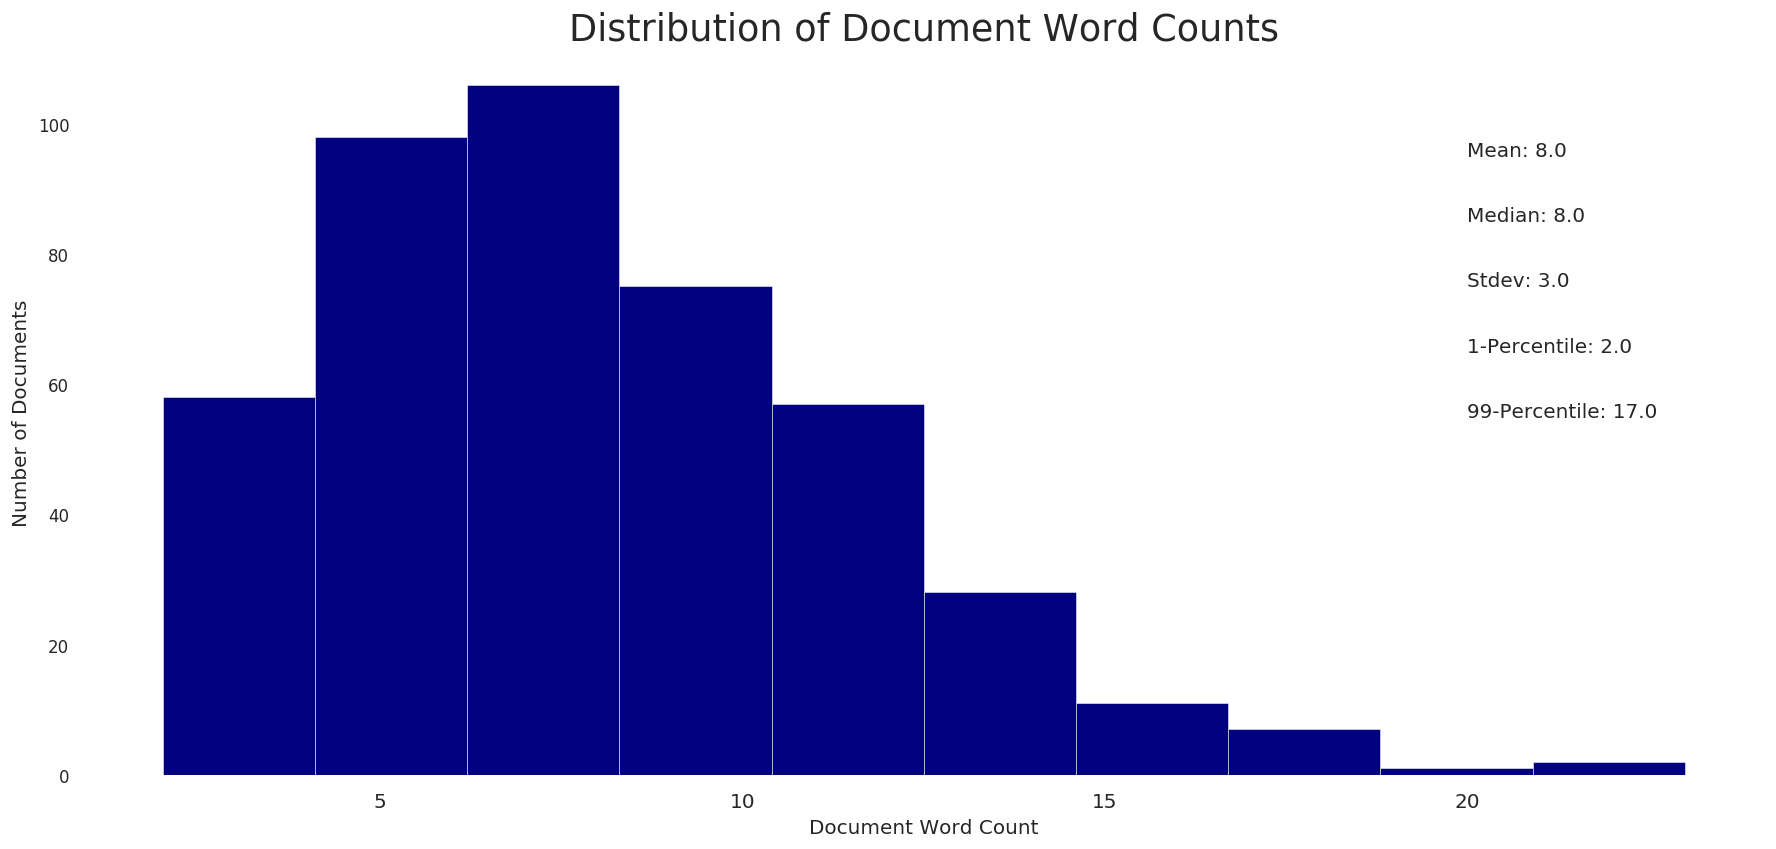

In [29]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=120)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

#### Word counts of topic keywords

In [30]:
# Formatting
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = list()
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
data = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

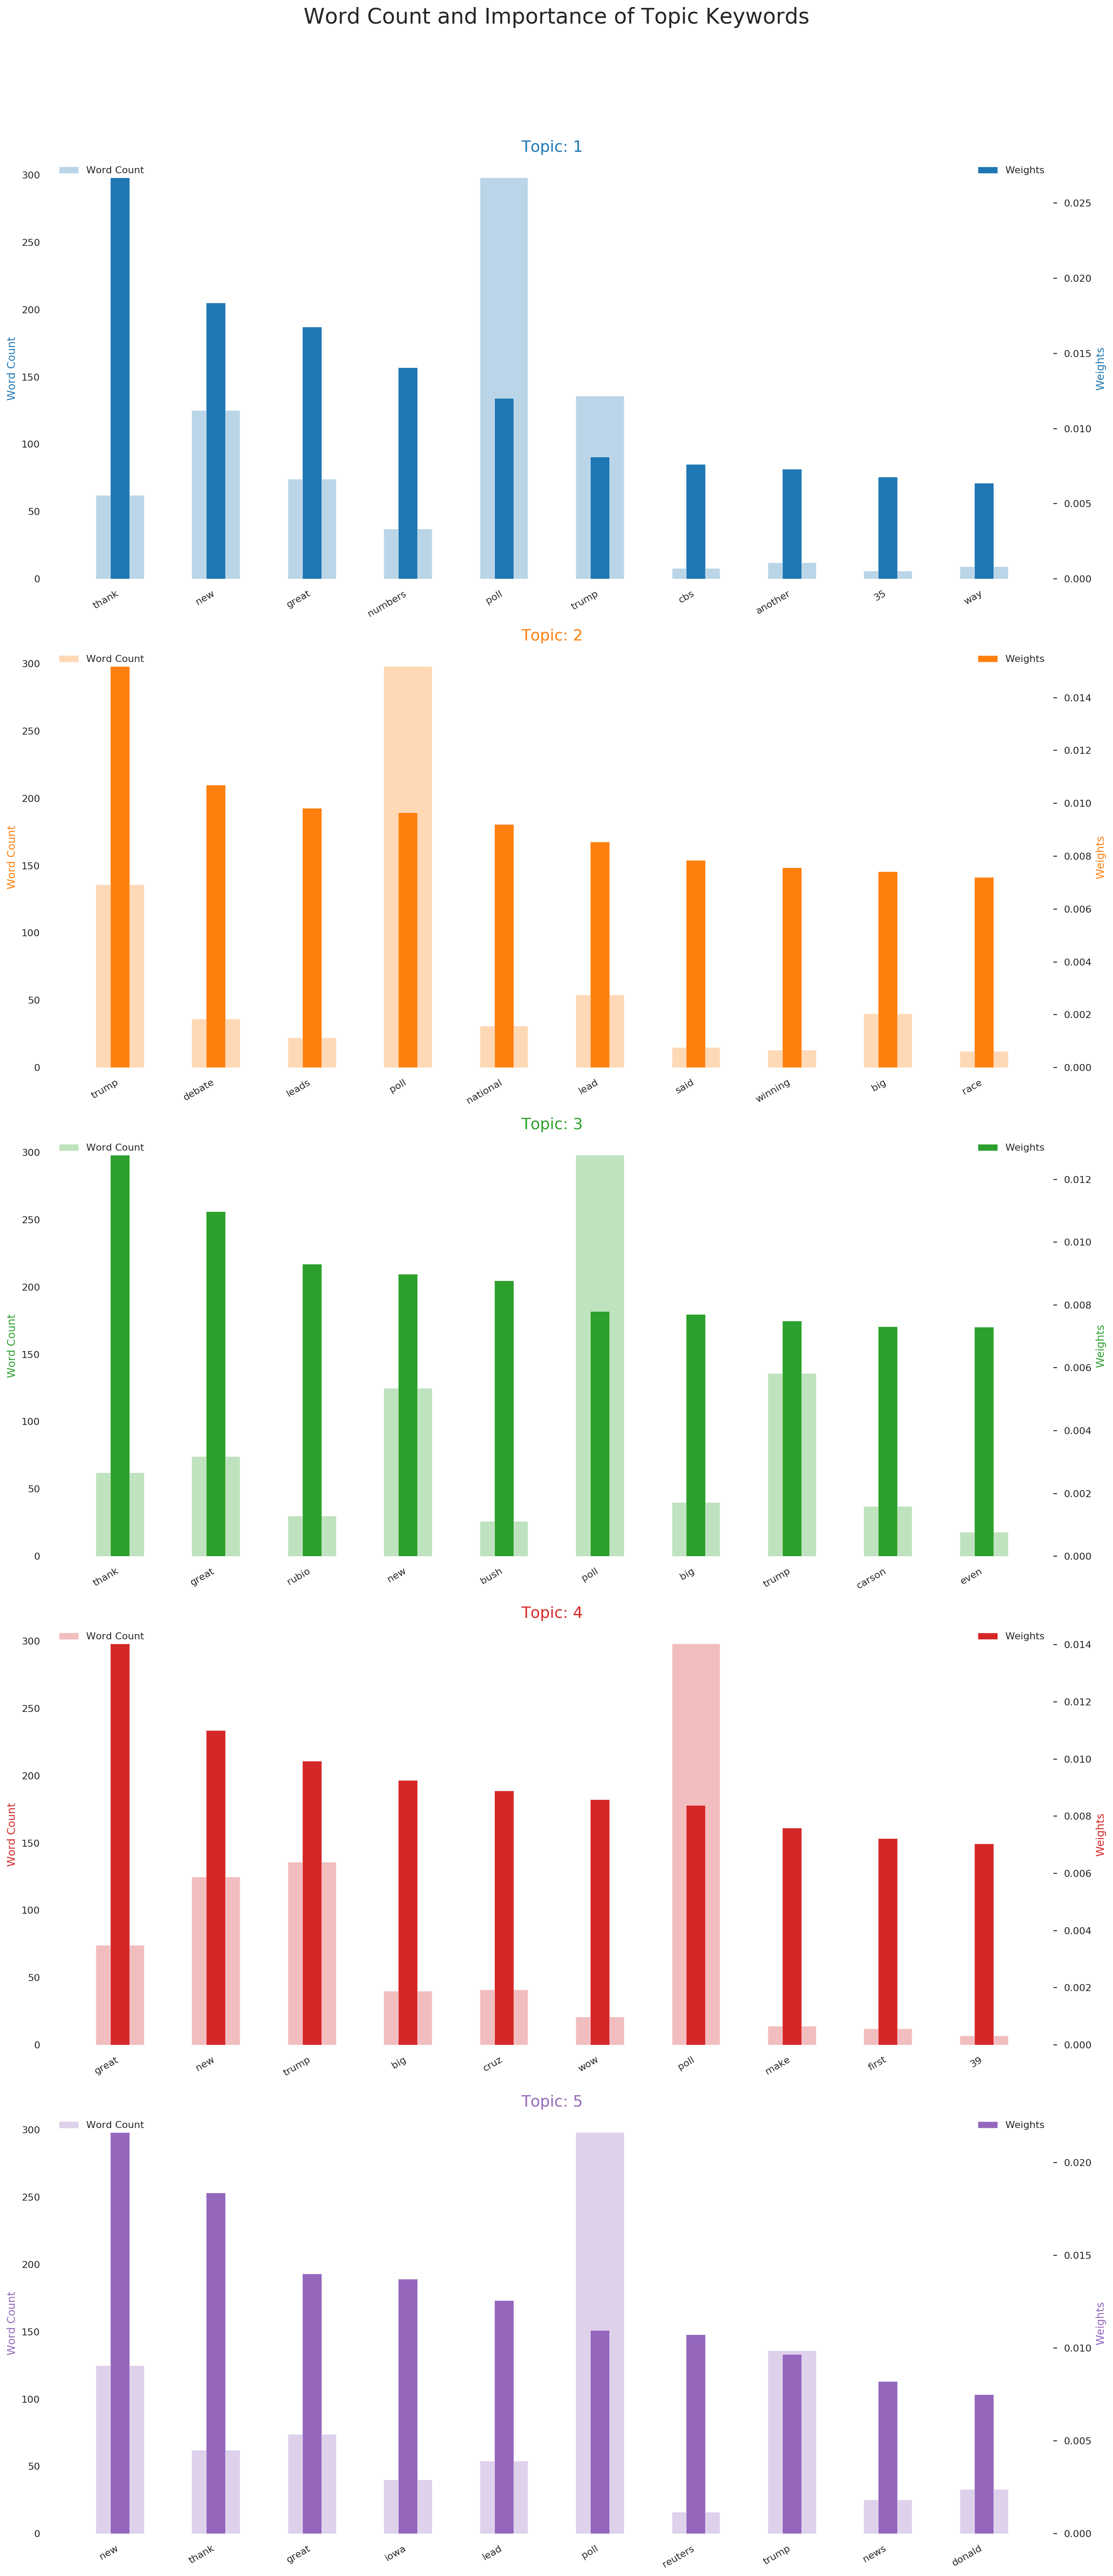

In [32]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 35), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

#### What are the most discussed topics in the tweets?

In [33]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [34]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [35]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [36]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

We will now make two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

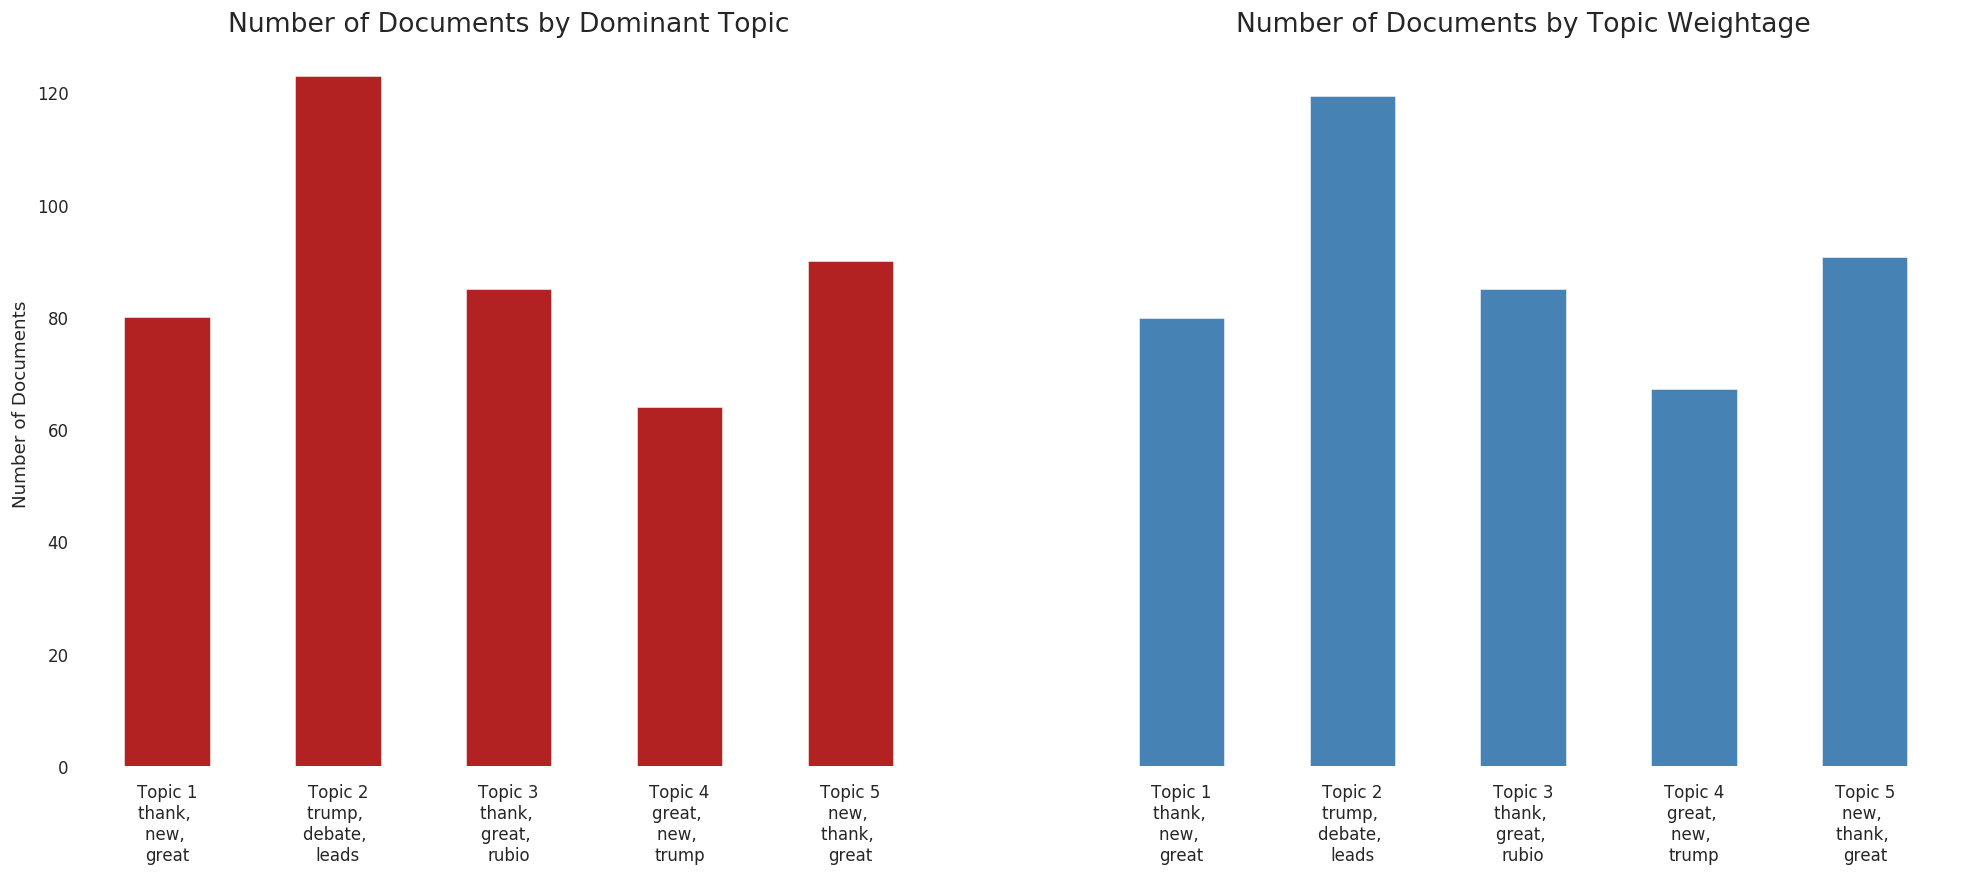

In [37]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

#### Polarity and subjectivity of sentiments

In [38]:
# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity, subjectivity = list(), list()
    for tweet in df[column]:
        blob = TextBlob(tweet)
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

polarity_and_subjectivity(df=df, column='text')

(None, None)

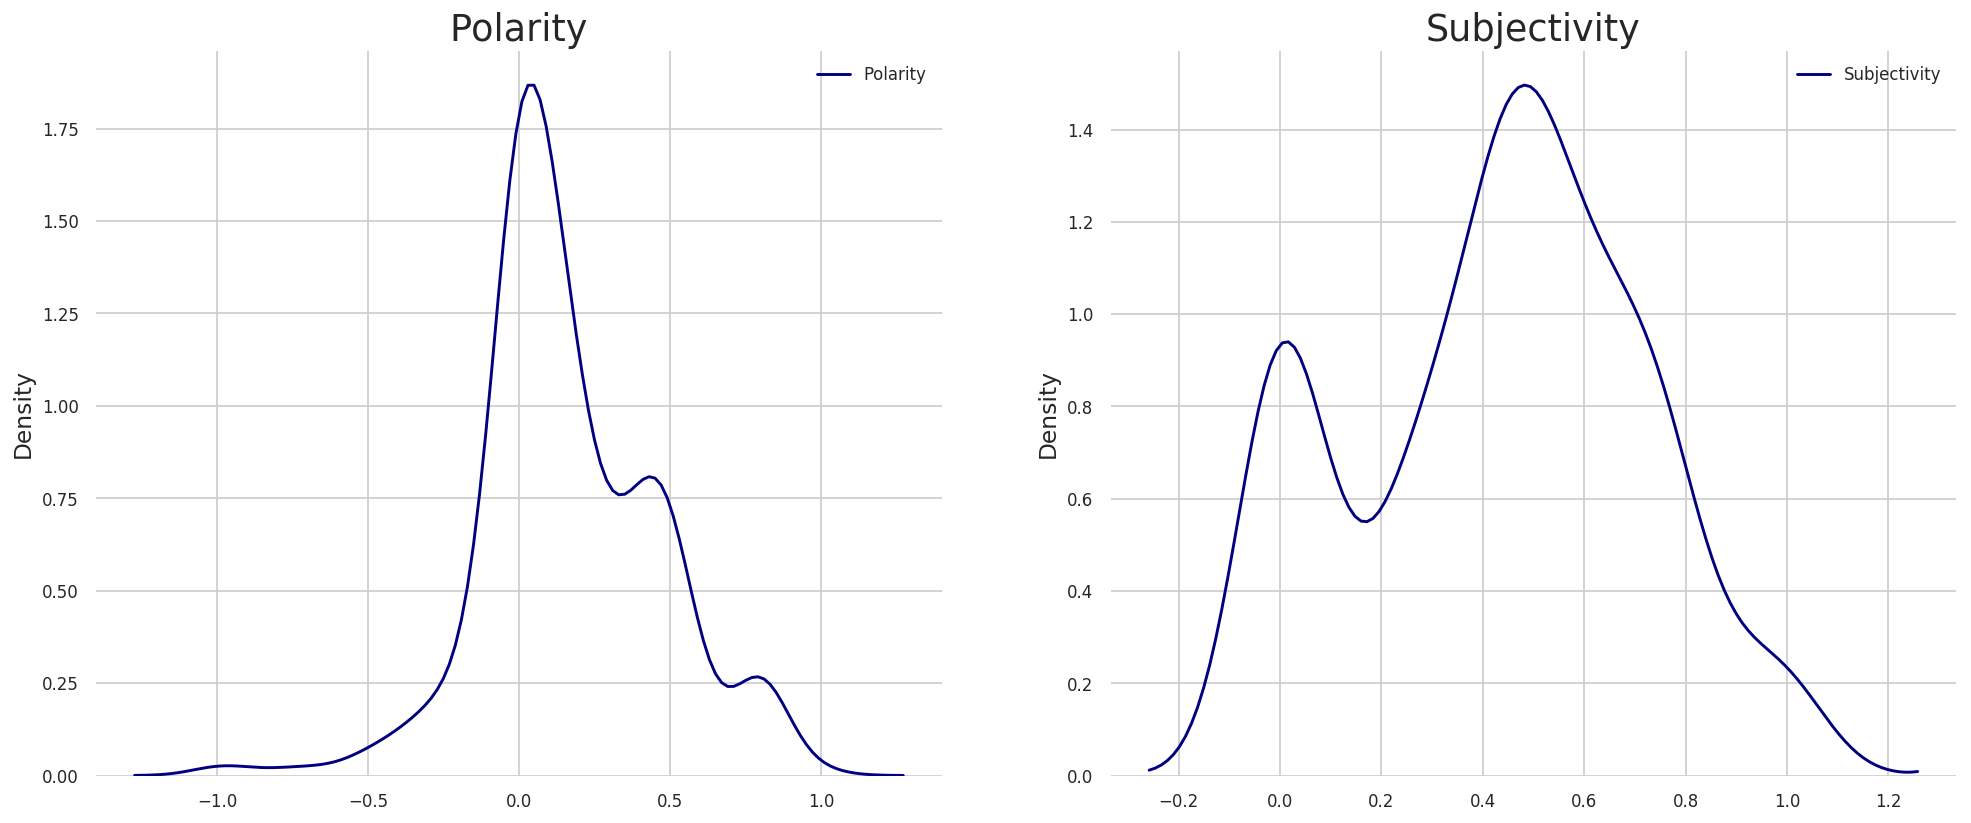

In [39]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120)
sns.distplot(df['polarity'], label='Polarity', ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], label='Subjectivity', ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14), ax2.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

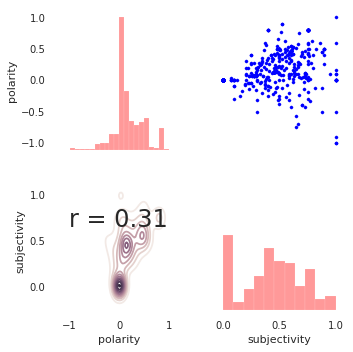

In [40]:
# Correlations
def correlations(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6),
                xycoords=ax.transAxes,
                size=24)

cmap = sns.cubehelix_palette(light=1, dark=.1, hue=.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pairgrid setup
g = sns.PairGrid(df.drop('id', axis=1))
# Scatterplot on upper triangle
g.map_upper(plt.scatter, s=10, color='blue')
# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color='red')
# Densityplot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap=cmap)
g.map_lower(correlations)

#### Comparison: Polarity and subjectivity

(None, None)

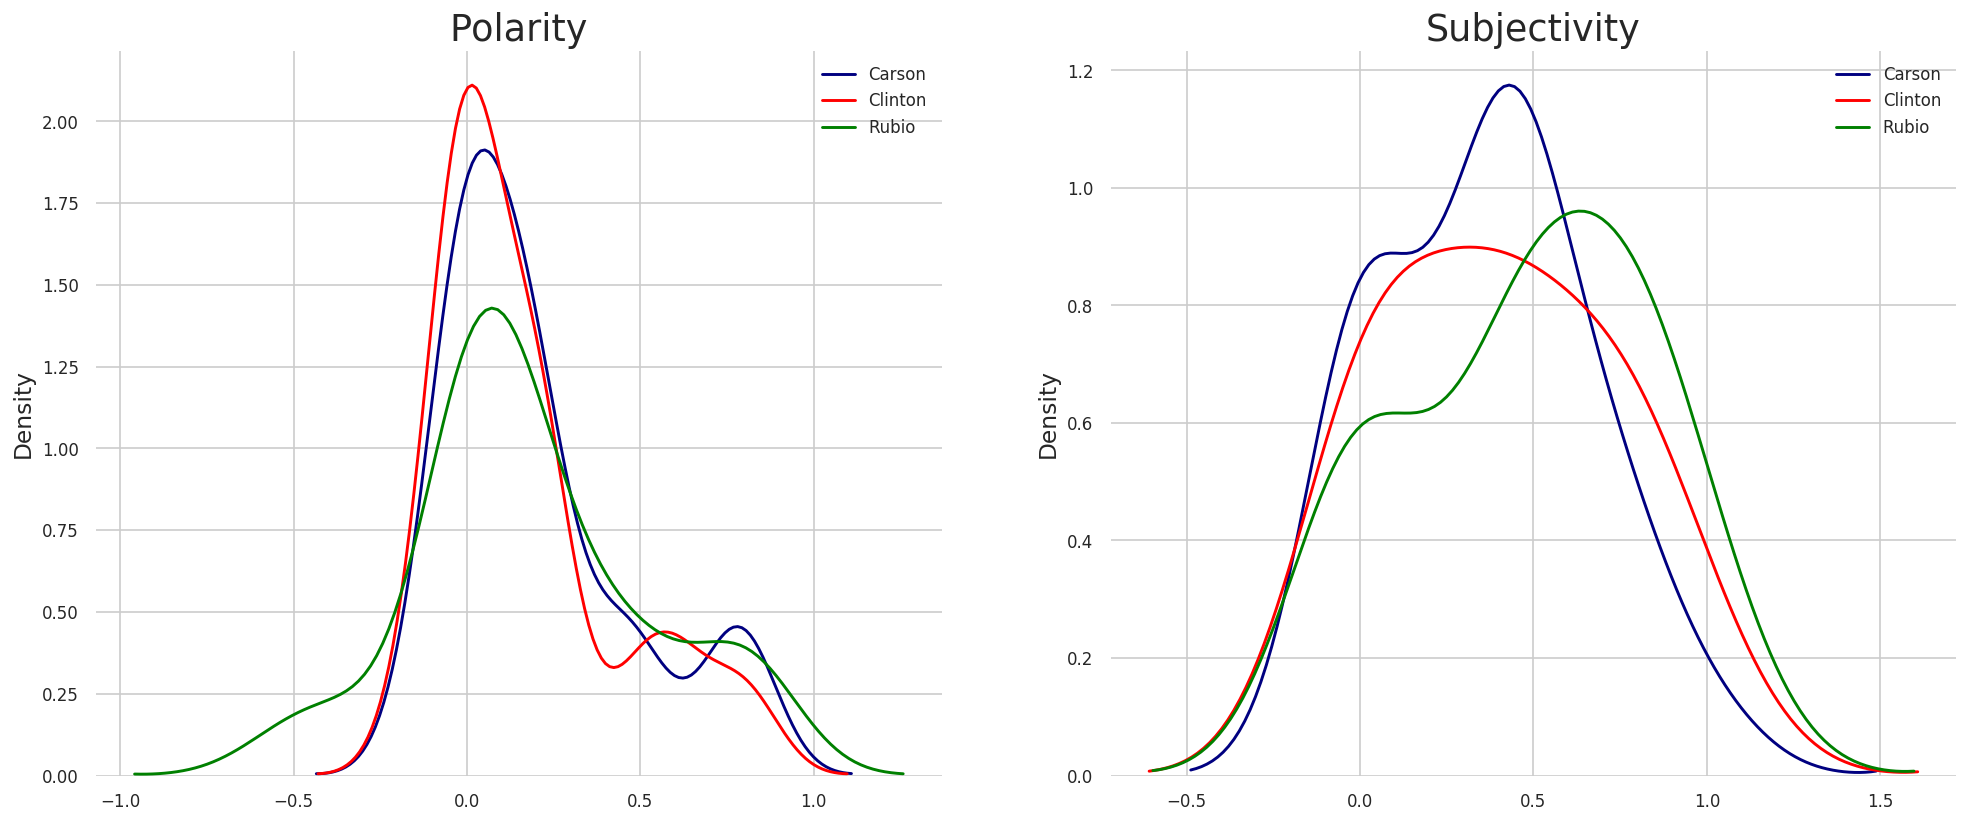

In [41]:
# Comparing subjectivity and polarity between candidates
carson = df.loc[df['text'].str.contains('Carson')]
clinton = df.loc[df['text'].str.contains('Clinton')]
rubio = df.loc[df['text'].str.contains('Rubio')]

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120)
sns.distplot(carson['polarity'], label='Carson', ax=ax1, color='navy', hist=False)
sns.distplot(clinton['polarity'], label='Clinton', ax=ax1, color='red', hist=False)
sns.distplot(rubio['polarity'], label='Rubio', ax=ax1, color='green', hist=False)
sns.distplot(carson['subjectivity'], label='Carson', ax=ax2, color='navy', hist=False)
sns.distplot(clinton['subjectivity'], label='Clinton', ax=ax2, color='red', hist=False)
sns.distplot(rubio['subjectivity'], label='Rubio', ax=ax2, color='green', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14), ax2.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Time series of polarity and subjectivity

In [42]:
# Creating time series objects
# Polarity
carson_polarity = ts.create_series(carson, 'created_at', 'polarity')
clinton_polarity = ts.create_series(clinton, 'created_at', 'polarity')
rubio_polarity = ts.create_series(rubio, 'created_at', 'polarity')

# Subjectivity
carson_subjectivity = ts.create_series(carson, 'created_at', 'subjectivity')
clinton_subjectivity = ts.create_series(clinton, 'created_at', 'subjectivity')
rubio_subjectivity = ts.create_series(rubio, 'created_at', 'subjectivity')

In [43]:
def smooth(x,window_len=11,window='hanning'):
    '''smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    '''

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    return np.convolve(w/w.sum(), s, mode='valid')

(None, None)

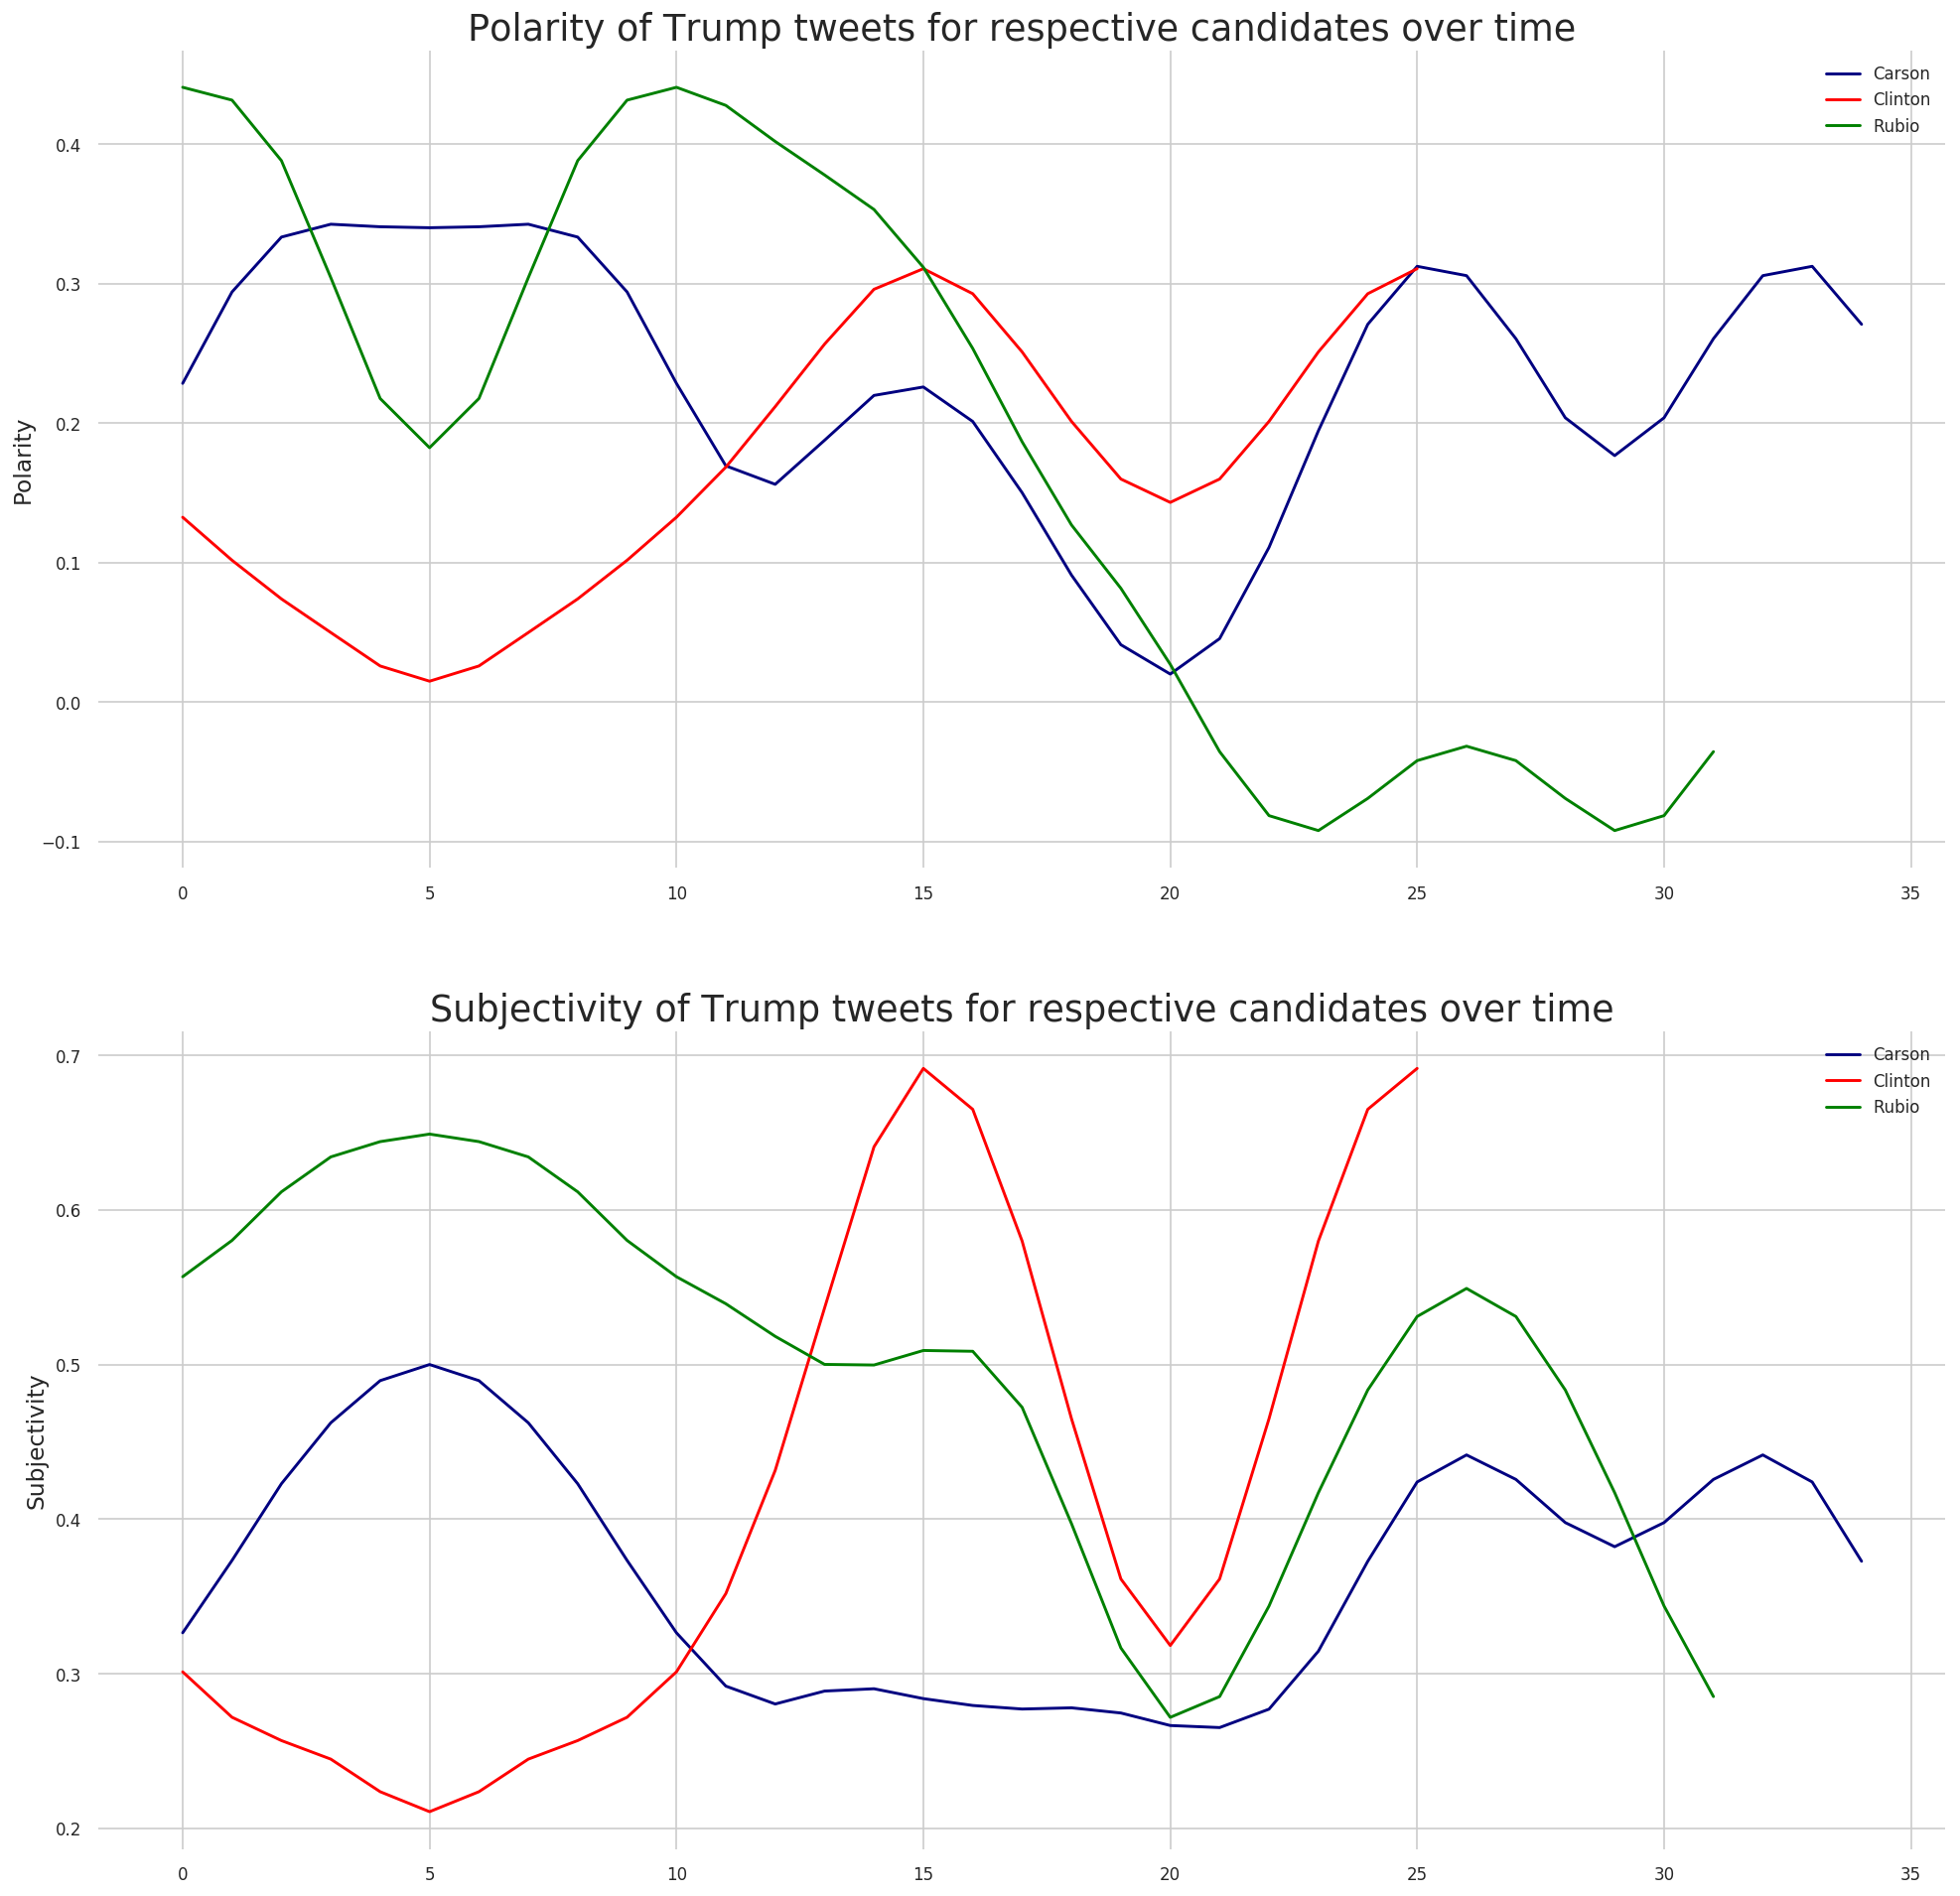

In [44]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=120)
sns.lineplot(data=smooth(carson_polarity), label='Carson', color='navy', ax=ax1)
sns.lineplot(data=smooth(clinton_polarity), label='Clinton', color='red', ax=ax1)
sns.lineplot(data=smooth(rubio_polarity), label='Rubio', color='green', ax=ax1)
sns.lineplot(data=smooth(carson_subjectivity), label='Carson', color='navy', ax=ax2)
sns.lineplot(data=smooth(clinton_subjectivity), label='Clinton', color='red', ax=ax2)
sns.lineplot(data=smooth(rubio_subjectivity), label='Rubio', color='green', ax=ax2)
ax1.set_title('Polarity of Trump tweets for respective candidates over time', fontsize=22)
ax2.set_title('Subjectivity of Trump tweets for respective candidates over time', fontsize=22)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_ylabel('Subjectivity', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()